**кейс по NLP для смены по машинному обучению от Тинькофф в Университете "Сириус". Выполнил Домрачев И.С.**

Установим зависимости, загрузим базовую модель и проверим работоспособность

In [ ]:
!pip install transformers accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.5 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained('tinkoff-ai/ruDialoGPT-medium')
model = AutoModelWithLMHead.from_pretrained('tinkoff-ai/ruDialoGPT-medium')
inputs = tokenizer('@@ПЕРВЫЙ@@ привет @@ВТОРОЙ@@ привет @@ПЕРВЫЙ@@ как дела? @@ВТОРОЙ@@', return_tensors='pt')
generated_token_ids = model.generate(
    **inputs,
    top_k=10,
    top_p=0.95,
    num_beams=3,
    num_return_sequences=3,
    do_sample=True,
    no_repeat_ngram_size=2,
    temperature=1.2,
    repetition_penalty=1.2,
    length_penalty=1.0,
    eos_token_id=50257,
    max_new_tokens=40
)
context_with_response = [tokenizer.decode(sample_token_ids) for sample_token_ids in generated_token_ids]
context_with_response


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1479: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:50257 for open-end generation.


['@@ПЕРВЫЙ@@ привет @@ВТОРОЙ@@ привет @@ПЕРВЫЙ@@ как дела? @@ВТОРОЙ@@нормально, а у тебя? как ты? что делаешь? чем занимаешься? я просто не в курсе 🤷🏻\u200d♀️🙄',
 '@@ПЕРВЫЙ@@ привет @@ВТОРОЙ@@ привет @@ПЕРВЫЙ@@ как дела? @@ВТОРОЙ@@нормально, а у тебя? как ты? что делаешь? чем занимаешься? я просто не в курсе 🤷🏻\u200d♀️😳�',
 '@@ПЕРВЫЙ@@ привет @@ВТОРОЙ@@ привет @@ПЕРВЫЙ@@ как дела? @@ВТОРОЙ@@нормально, а у тебя? как ты? что делаешь? чем занимаешься? я просто не в курсе 🤷🏻\u200d♀️🙂']

Модель работает, приступим к предобработке данных и дообучению модели на наших данных. За основу я беру данные из чата общежития "ДАС" МГУ. Темы общения - учеба, жизнь в общаге, быт. Присутствуют нецензурные слова.

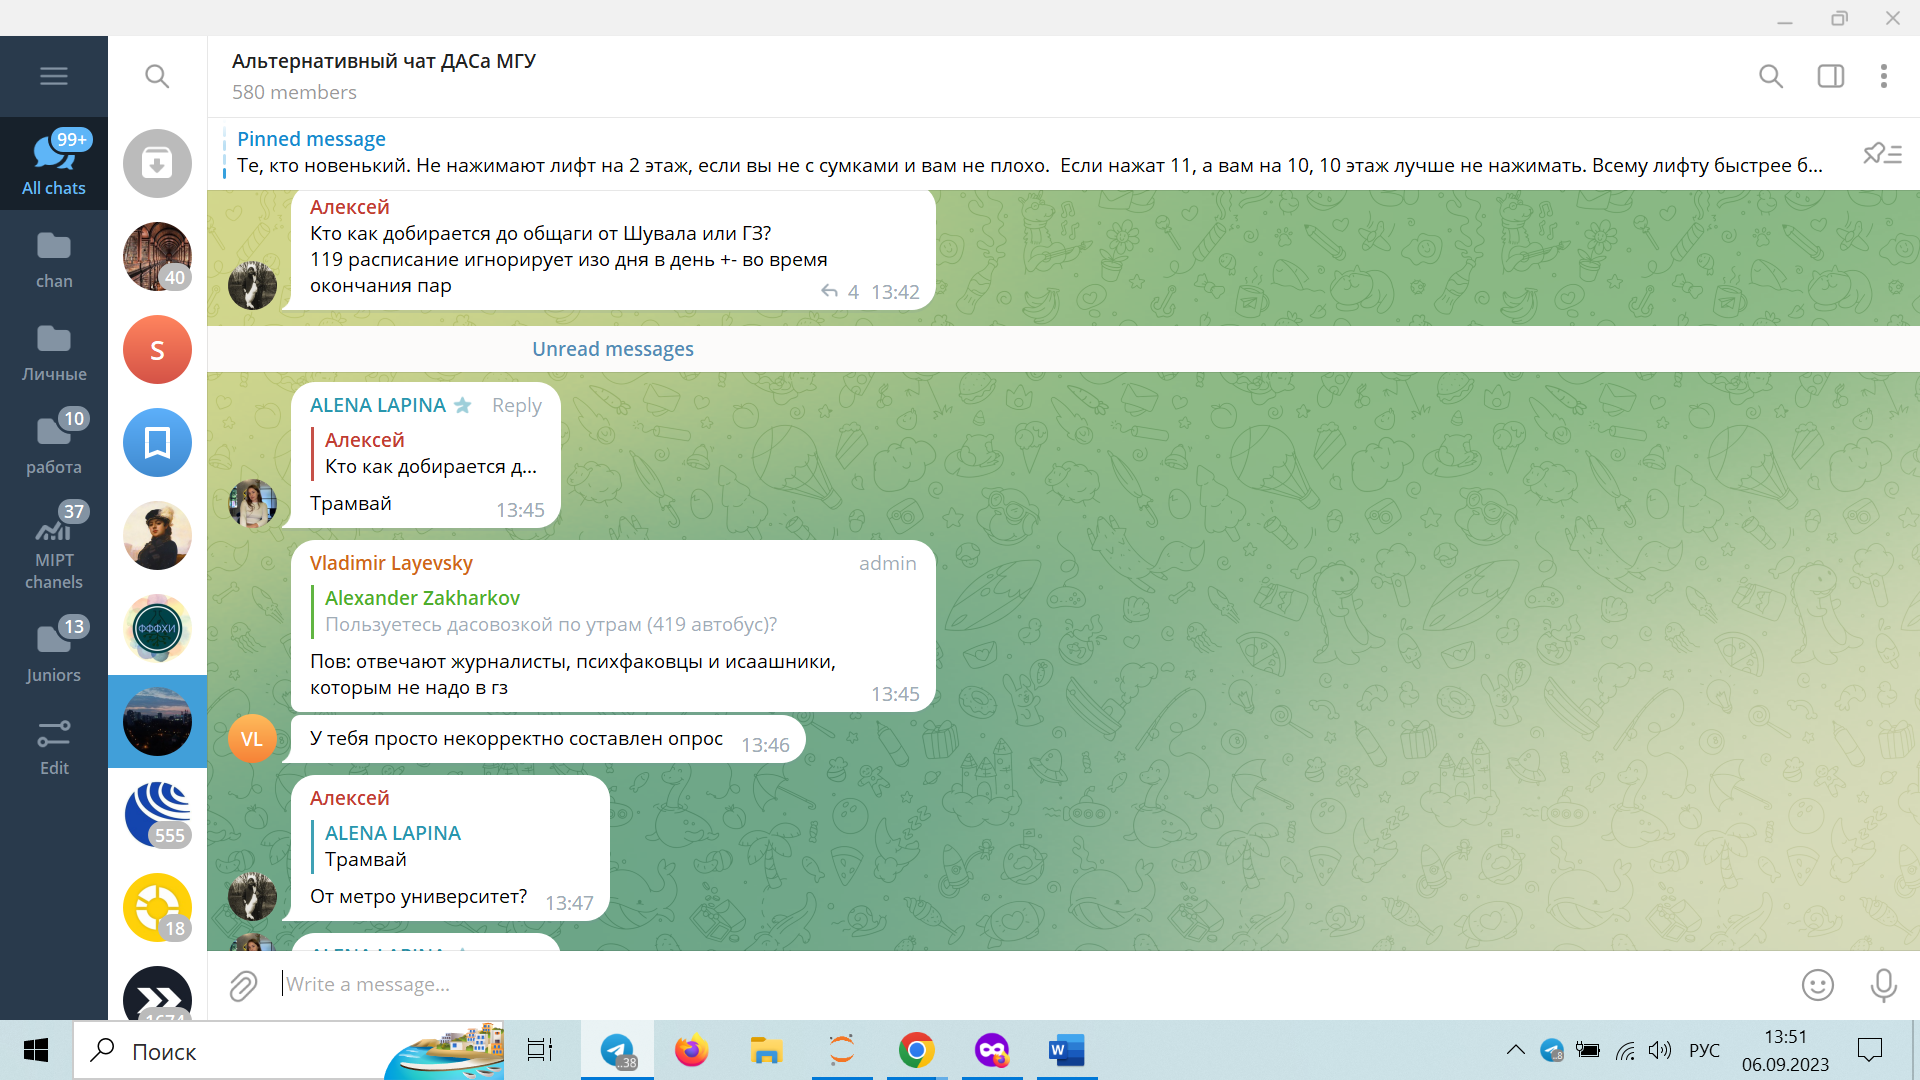

Подготовим данные с помощью скрипта из задания, преобразуем в нужный вид

In [ ]:
!git clone https://github.com/solemn-leader/sirius-test
# клонируем репозиторий задания

Cloning into 'sirius-test'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 27 (delta 6), reused 1 (delta 0), pack-reused 0
Receiving objects: 100% (27/27), 793.30 KiB | 18.03 MiB/s, done.
Resolving deltas: 100% (6/6), done.


Json файл result.json экспортирован из телеграма. приведем его к виду датафрейма.

In [7]:
!python ../../content/sirius-test/prepare_messages.py --tg-history-path './sirius-test/result.json' --output-path 'sirius-test/das_messages.csv'
# обрабатываем json, преобразуем в csv таблицу

In [54]:
import pandas as pd

data = pd.read_csv('../../content/sirius-test/das_messages.csv', encoding='utf-8')
data = data.dropna()
data[1900:1950] # пример данных

,context_3,context_2,context_1,response
11338,Это вещи разных порядков. Не любое насилие с т...,Так что всем с суицидалтными мыслями советую б...,Вот убийцу могут в тюрьму посадить. Это принуд...,"Честно не совсем понимаю о чем ты, но да ладно"
11349,вроде,"Кстати, спасибо за ответ\nПомогла\n*теперь не ...",Лечиться надо и вылечиться возможно,"Лечение - это мистификация\nЛадно, тема серьёз..."
11367,Вот кого надо бы положить в больничку,"Нет, только если к гос психологу. Плюс там под...","Окей, я понял","Едем с Амирой в междугороднем автобусе, зацени..."
11368,"Нет, только если к гос психологу. Плюс там под...","Окей, я понял","Едем с Амирой в междугороднем автобусе, зацени...",аххахаххахак скину Феде
11377,Дядя Толя,парикмахер дядя толик подстриги меня под нолик,"Я уснуть не могу, потому что у меня в голове т...",аххахаххахак прости
11384,"Кстати, а почему у нас в Дасе так? Я не претен...",Всё верно написано на двери),не верно же...уже давно говорят запасной,https://www.google.com/amp/s/aif.ru/amp/societ...
11406,"Судя по всему, кроме меня сегодня дежурить ник...","Бро, я сегодня до полуночи работаю(","После подходи. Я до половины второго там буду,...",Я уже не встану ахах\nСегодня до смены три с п...
11416,лол,Кто?,Крутой вопрос,кто
11417,Кто?,Крутой вопрос,кто,У кого-то есть томагавк?\nНа практику взять…..
11418,Крутой вопрос,кто,У кого-то есть томагавк?\nНа практику взять…..,Не тот шеринг\nВот он сука


In [30]:
import pandas as pd
import numpy as np
import os

import time
from transformers import AutoTokenizer, AutoModelWithLMHead, GPT2Tokenizer, GPT2LMHeadModel, TextDatasetForNextSentencePrediction, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader

подготовим тексты и сформируем датасет

In [10]:
#tokenizer = AutoTokenizer.from_pretrained('tinkoff-ai/ruDialoGPT-medium')

def delete_newlines(text):
    text = text.replace('\n', ' ')
    return text
def preprocess_data(path_to_dataset, wnd):
    input_texts = []
    target_texts = []
    df = pd.read_csv(path_to_dataset)
    start = wnd[0]
    end = wnd[1]
    df = df[start:end]
    df = df.dropna()
    for col in df.columns:
        df[col] = df[col].apply(delete_newlines)

    for index, row in df.iterrows():
        input_text = f"[Q] @@ПЕРВЫЙ@@ {row['context_3']} @@ВТОРОЙ@@ {row['context_2']} @@ПЕРВЫЙ@@ {row['context_1']} [A] @@ВТОРОЙ@@ {row['response']}"
        target_text = f"{row['response']} {tokenizer.eos_token}"
        input_texts.append(input_text)
        target_texts.append(target_text)

    return input_texts, target_texts, df

path_to_dataset = '../../content/sirius-test/das_messages.csv'
window = (500, 1000)  # диапазон данных
input_texts, target_texts, df = preprocess_data(path_to_dataset, window)


In [11]:
input_texts[1:3]

['[Q] @@ПЕРВЫЙ@@ Вадим обитает в бОльшем количестве чатов даса, чем в самом дасе @@ВТОРОЙ@@ Да, я такой. @@ПЕРВЫЙ@@ Блин, какая жалость [A] @@ВТОРОЙ@@ Я очень ждала что он придет…',
 '[Q] @@ПЕРВЫЙ@@ Да, я такой. @@ВТОРОЙ@@ Блин, какая жалость @@ПЕРВЫЙ@@ Я очень ждала что он придет… [A] @@ВТОРОЙ@@ Может не увидел еще Будет писать и удалять сообщения']

In [12]:
target_texts[1:3]

['Я очень ждала что он придет… <|endoftext|>',
 'Может не увидел еще Будет писать и удалять сообщения <|endoftext|>']

In [13]:
max_input_length=64
max_target_length=64
input_encodings = tokenizer(
        input_texts,
        max_length=max_input_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
target_encodings = tokenizer(
    target_texts,
    max_length=max_target_length,
    padding='max_length',
    truncation=True,
    return_tensors='pt')

In [31]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, input_encodings, target_encodings):
        self.input_encodings = input_encodings
        self.target_encodings = target_encodings

    def __len__(self):
        return len(self.input_encodings['input_ids'])

    def __getitem__(self, idx):
        input_ids = self.input_encodings['input_ids'][idx]
        attention_mask = self.input_encodings['attention_mask'][idx]
        target_ids = self.target_encodings['input_ids'][idx]
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': target_ids
        }


In [32]:
dataset = MyDataset(input_encodings, target_encodings)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [16]:
training_args = TrainingArguments(
    output_dir='./fine-tuned-model',  # Путь к папке, где сохранится дообученная модель
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    save_steps=100,
)


In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False),
    train_dataset=dataset
)


trainer.train()


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


TrainOutput(global_step=201, training_loss=1.998879352019201, metrics={'train_runtime': 2021.0764, 'train_samples_per_second': 0.197, 'train_steps_per_second': 0.099, 'total_flos': 46318947139584.0, 'train_loss': 1.998879352019201, 'epoch': 3.0})

In [18]:
model.save_pretrained('fine-tuned-model')


Модель дообучена и сохранена.

In [22]:
!cp -r /content/fine-tuned-model /content/drive/MyDrive

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Проверим работоспособность дообученной модели на новых данных.

In [34]:
inputs = tokenizer('@@ПЕРВЫЙ@@ привет, как дела в общаге? @@ВТОРОЙ@@', return_tensors='pt')
generated_token_ids = model.generate(
    **inputs,
    top_k=10,
    top_p=0.95,
    num_beams=3,
    num_return_sequences=3,
    do_sample=True,
    no_repeat_ngram_size=2,
    temperature=5.2,
    repetition_penalty=1.2,
    length_penalty=1.0,
    eos_token_id=50257,
    max_new_tokens=40
)
context_with_response = [tokenizer.decode(sample_token_ids) for sample_token_ids in generated_token_ids]
context_with_response

Setting `pad_token_id` to `eos_token_id`:50257 for open-end generation.


['@@ПЕРВЫЙ@@ привет, как дела в общаге? @@ВТОРОЙ@@ все ещё ждем подписей ваших родителей... а то вдруг не достаточно подписей собрали или что-то еще) @@ПЕРВЫЙ@@',
 '@@ПЕРВЫЙ@@ привет, как дела в общаге? @@ВТОРОЙ@@ все ещё ждем подписи ректора @@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@',
 '@@ПЕРВЫЙ@@ привет, как дела в общаге? @@ВТОРОЙ@@ все ещё ждем подписей ваших родителей... @@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@']

In [35]:
inputs = tokenizer('@@ПЕРВЫЙ@@ привет @@ВТОРОЙ@@ привет @@ПЕРВЫЙ@@ как дела? @@ВТОРОЙ@@', return_tensors='pt')
generated_token_ids = model.generate(
    **inputs,
    top_k=10,
    top_p=0.95,
    num_beams=3,
    num_return_sequences=3,
    do_sample=True,
    no_repeat_ngram_size=2,
    temperature=1.2,
    repetition_penalty=1.2,
    length_penalty=1.0,
    eos_token_id=50257,
    max_new_tokens=40
)
context_with_response = [tokenizer.decode(sample_token_ids) for sample_token_ids in generated_token_ids]
context_with_response

Setting `pad_token_id` to `eos_token_id`:50257 for open-end generation.


['@@ПЕРВЫЙ@@ привет @@ВТОРОЙ@@ привет @@ПЕРВЫЙ@@ как дела? @@ВТОРОЙ@@ отлично! А у тебя? [A] ]@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@',
 '@@ПЕРВЫЙ@@ привет @@ВТОРОЙ@@ привет @@ПЕРВЫЙ@@ как дела? @@ВТОРОЙ@@ отлично! А у тебя?@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@',
 '@@ПЕРВЫЙ@@ привет @@ВТОРОЙ@@ привет @@ПЕРВЫЙ@@ как дела? @@ВТОРОЙ@@ отлично! А у тебя как? [A] ]@@ПЕРВЫЙ@@']

In [37]:
inputs = tokenizer('@@ПЕРВЫЙ@@ Воняет на всю комнату	 @@ВТОРОЙ@@ а что он такое готовит? @@ПЕРВЫЙ@@ Варит миллиард приправ в воде @@ВТОРОЙ@@', return_tensors='pt')
generated_token_ids = model.generate(
    **inputs,
    top_k=10,
    top_p=0.95,
    num_beams=3,
    num_return_sequences=3,
    do_sample=True,
    no_repeat_ngram_size=2,
    temperature=1.2,
    repetition_penalty=1.2,
    length_penalty=1.0,
    eos_token_id=50257,
    max_new_tokens=40
)
context_with_response = [tokenizer.decode(sample_token_ids) for sample_token_ids in generated_token_ids]
context_with_response
#Воняет на всю комнату	а что он такое готовит?	Варит миллиард приправ в воде	вкусно

Setting `pad_token_id` to `eos_token_id`:50257 for open-end generation.


['@@ПЕРВЫЙ@@ Воняет на всю комнату\t @@ВТОРОЙ@@ а что он такое готовит? @@ПЕРВЫЙ@@ Варит миллиард приправ в воде @@ВТОРОЙ@@ ты шутишь или да на самом деле это пиздец. Я в ахуе просто. Это что за суп такой? О_о [A]  А вообще, конечно, круто, что',
 '@@ПЕРВЫЙ@@ Воняет на всю комнату\t @@ВТОРОЙ@@ а что он такое готовит? @@ПЕРВЫЙ@@ Варит миллиард приправ в воде @@ВТОРОЙ@@ ты шутишь или да на самом деле это пиздец. Я в ахуе просто. Это что за суп такой? О_о [A]  P.S. я не шучу',
 '@@ПЕРВЫЙ@@ Воняет на всю комнату\t @@ВТОРОЙ@@ а что он такое готовит? @@ПЕРВЫЙ@@ Варит миллиард приправ в воде @@ВТОРОЙ@@ ты шутишь или да на самом деле это пиздец. Я в ахуе просто. Это что за суп такой? О_о [A]  P.S. я повар. Но']

In [38]:
#А у меня коменда украла кастрюлю с пшеном	Или это не коменда	Здравствуйте я коменда я вынуждена конфисковат...
inputs = tokenizer('@@ПЕРВЫЙ@@ А у меня коменда украла кастрюлю с пшеном	 @@ВТОРОЙ@@ Или это не коменда @@ПЕРВЫЙ@@ ', return_tensors='pt')
generated_token_ids = model.generate(
    **inputs,
    top_k=10,
    top_p=0.95,
    num_beams=3,
    num_return_sequences=3,
    do_sample=True,
    no_repeat_ngram_size=2,
    temperature=1.2,
    repetition_penalty=1.2,
    length_penalty=1.0,
    eos_token_id=50257,
    max_new_tokens=40
)
context_with_response = [tokenizer.decode(sample_token_ids) for sample_token_ids in generated_token_ids]
context_with_response

Setting `pad_token_id` to `eos_token_id`:50257 for open-end generation.


['@@ПЕРВЫЙ@@ А у меня коменда украла кастрюлю с пшеном\t @@ВТОРОЙ@@ Или это не коменда @@ПЕРВЫЙ@@ 🤔🗿 [A]  Вангую, что это был сарказм. Ну или нет причин не доверять человеку с ником "Коменда" 😄 [B]',
 '@@ПЕРВЫЙ@@ А у меня коменда украла кастрюлю с пшеном\t @@ВТОРОЙ@@ Или это не коменда @@ПЕРВЫЙ@@ 🤔🗿 [A]  Вангую, что это был сарказм. Ну или нет причин не доверять человеку с ником "Коменда" 😂 [B]',
 '@@ПЕРВЫЙ@@ А у меня коменда украла кастрюлю с пшеном\t @@ВТОРОЙ@@ Или это не коменда @@ПЕРВЫЙ@@ 🤔🗿 [A]  Вангую, что это был сарказм. Ну или нет причин не доверять человеку с ником "Коменда" 😄 [O]']

In [52]:
# Ребята, парацетамол помогает от головы?	неа. лучше цитрамон, проверенное средство	Основа цитрамона -- парацетамол)	Ацетилсалициловая кислота+Кофеин+Парацетамол\n...

inputs = tokenizer('@@ПЕРВЫЙ@@ Ребята, парацетамол помогает от головы? @@ВТОРОЙ@@  ', return_tensors='pt')
generated_token_ids = model.generate(
    **inputs,
    top_k=30,
    top_p=0.95,
    num_beams=3,
    num_return_sequences=3,
    do_sample=True,
    no_repeat_ngram_size=2,
    temperature=2.2,
    repetition_penalty=1.2,
    length_penalty=1.0,
    eos_token_id=50257,
    max_new_tokens=40
)
context_with_response = [tokenizer.decode(sample_token_ids) for sample_token_ids in generated_token_ids]
context_with_response

Setting `pad_token_id` to `eos_token_id`:50257 for open-end generation.


['@@ПЕРВЫЙ@@ Ребята, парацетамол помогает от головы? @@ВТОРОЙ@@   От всего помогает Но лучше конечно чтобы помогал аспирин 🥺🤧\u200d♀️@@ПЕРВЫЙ@@',
 '@@ПЕРВЫЙ@@ Ребята, парацетамол помогает от головы? @@ВТОРОЙ@@   От всего помогает Но лучше конечно чтобы помогал аспирин 🥺🤧🏻@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@',
 '@@ПЕРВЫЙ@@ Ребята, парацетамол помогает от головы? @@ВТОРОЙ@@   От всего помогает Но лучше конечно чтобы помогал аспирин 🥺🤔@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@@@ПЕРВЫЙ@@']

В итоге имеем рабочую модель, примеры результатов:

**Вход**:  Ребята, парацетамол помогает от головы?

**Выход**: От всего помогает Но лучше конечно чтобы помогал аспирин 🥺🤧🏻

**Вход** : А у меня коменда украла кастрюлю с пшеном Или это не коменда

**Выход**:  Вангую, что это был сарказм. Ну или нет причин не доверять человеку с ником "Коменда" 😄

**Вход**: '@@ПЕРВЫЙ@@ Воняет на всю комнату\t @@ВТОРОЙ@@ а что он такое готовит? @@ПЕРВЫЙ@@ Варит миллиард приправ в воде

**Выход**: @@ВТОРОЙ@@ ты шутишь или да на самом деле это #####. Я в #### просто. Это что за суп такой? О_о [A]  P.S. я не шучу'

**Вход**: @@ПЕРВЫЙ@@ привет @@ВТОРОЙ@@ привет @@ПЕРВЫЙ@@ как дела?
**Выход**: @@ВТОРОЙ@@ отлично! А у тебя?
